# Setup

In [91]:
import json
import os
import sys
import pickle
import warnings
import time

sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from flaml import AutoML

from sklearn.metrics import balanced_accuracy_score

from utils import read_csv_non_utf, preprocess_data, ratios_to_DI_cats, get_train_test_split, get_zero_nonzero_datasets, test_thresholds
from performance_reports import get_regression_report, get_classification_report

## Helper functions

In [25]:
def balanced_accuracy_FLAML(X_val, y_val, estimator, labels, X_train, y_train, 
                            weight_val = None, weight_train = None, *args):

    start = time.time()
    y_pred = estimator.predict(X_val)
    pred_time = (time.time() - start) / len(X_val)
    val_acc = 1.0 - balanced_accuracy_score(y_val, y_pred)
    
    return val_acc, {'val_acc' : val_acc, 'pred_time' : pred_time}

In [52]:
def get_train_test_data(ben_lop2019, train_size, task = 'classification'):
    # Getting the shared basic train/test split
    idxs = get_train_test_split(len(ben_lop2019), train_size = train_size)
    
    # Pre-processing data
    pp_data = preprocess_data(ben_lop2019, include_indicators = False, standardize = True, log_trans_cont = False,
                              polynomial_features = 0, train_test_idxs = idxs)
    pp_data['DI_cat'] = ratios_to_DI_cats(pp_data['ratio'])
    
    #  splitting the actual dataset into train/test sets
    train_data, test_data = pp_data.loc[idxs['train']], pp_data.loc[idxs['test']]
    
    #  putting into the format that FLAML wants
    target_col = 'ratio' if task == 'regression' else 'DI_cat'
    
    X_train, X_test = train_data.drop(columns = ['ratio', 'DI_cat']), test_data.drop(columns = ['ratio', 'DI_cat'])
    y_train, y_test = train_data[target_col].values, test_data[target_col].values

    return X_train, y_train, X_test, y_test

## Loading the data

In [5]:
# Loading in general configuration
with open('../config.json', 'r') as f:
    config = json.load(f)

# Getting filepaths
gdrive_fp = config['gdrive_path']
LIFE_fp = config['LIFE_folder']
dataset_fp = config['datasets_path']
benitez_lopez2019 = config['indiv_data_paths']['benitez_lopez2019']

data_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, benitez_lopez2019)

In [6]:
# Reading in data as a pandas dataframe
ben_lop2019 = read_csv_non_utf(data_path)

In [45]:
# Getting train/test data
task = 'classification'
X_train, y_train, X_test, y_test = get_train_test_data(ben_lop2019, train_size = 0.7, task = task)

print(f'{task.upper()} TARGET')
print(f'Train shape: X{X_train.shape}, y{y_train.shape}')
print(f'Test shape: X{X_test.shape}, y{y_test.shape}')

CLASSIFICATION TARGET
Train shape: X(2296, 8), y(2296,)
Test shape: X(985, 8), y(985,)


# Direct regression and classificaiton

I am using Microsoft's [`flaml`](https://github.com/microsoft/FLAML) for AutoML, which supports a range of models: 
- [Light Gradient Boosting Machine (LGBM)](https://github.com/microsoft/LightGBM),
- [Extreme Gradient Boosting (XGBoost)](https://github.com/dmlc/xgboost),
- [Random Forest (RF)](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor),
- [Extra Trees](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html),
- [Histogram Gradient Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor),
- [Categorical Boosting (CatBoost)](https://github.com/catboost/catboost),
- [$k$-Nearest Neighbors ($k$-NN)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html).

Noticeably, linear models and neural networks are missing from the mix, but we may be able to use `flaml` to perform [efficient hyperparameter tuning](https://microsoft.github.io/FLAML/docs/Use-Cases/Task-Oriented-AutoML#guidelines-on-tuning-a-custom-estimator) on these using `sklearn` or `PyTorch` implementations.

In [32]:
# Initialize the auto ML instance
automl = AutoML()
time_budget_mins = 5

# Specify paramaters
base_path = os.path.join('..', 'model_saves', f'direct_{task}')
automl_settings = {
    'time_budget' : time_budget_mins * 60,  # in seconds
    'metric' : 'mae' if task == 'regression' else balanced_accuracy_FLAML,
    'task' : task,
    'log_file_name' : os.path.join(base_path, f'mammals_direct_{task}.log'),
    'seed' : 1693,
    'estimator_list' : ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree', 'kneighbor'],
    'early_stop' : True,
    'verbose' : 3
}

# Train with labeled input data
automl.fit(X_train = X_train, y_train = y_train, **automl_settings)

[flaml.automl.logger: 05-23 15:31:59] {1680} INFO - task = classification
[flaml.automl.logger: 05-23 15:31:59] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 05-23 15:31:59] {1789} INFO - Minimizing error metric: customized metric
[flaml.automl.logger: 05-23 15:31:59] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree', 'kneighbor']
[flaml.automl.logger: 05-23 15:31:59] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 05-23 15:31:59] {2345} INFO - Estimated sufficient time budget=910s. Estimated necessary time budget=9s.
[flaml.automl.logger: 05-23 15:31:59] {2392} INFO -  at 0.2s,	estimator lgbm's best error=0.6667,	best estimator lgbm's best error=0.6667
[flaml.automl.logger: 05-23 15:31:59] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 05-23 15:31:59] {2392} INFO -  at 0.3s,	estimator lgbm's best error=0.5427,	best estimator lgbm's best error=0.5427
[flaml.automl.logger: 05

CLASSIFICATION PERFORMANCE
--------------------------
              precision    recall  f1-score   support

         low       0.82      0.80      0.81       560
      medium       0.41      0.43      0.42       207
        high       0.54      0.54      0.54       218

    accuracy                           0.67       985
   macro avg       0.59      0.59      0.59       985
weighted avg       0.67      0.67      0.67       985

Balanced accuracy: 59.11%


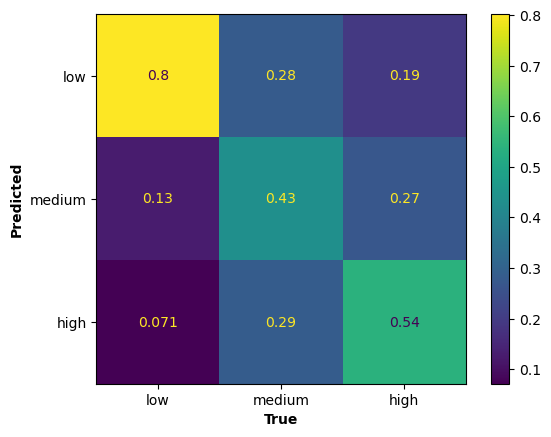

In [33]:
# Getting regression and classification true vs. predicted
if task == 'regression':
    pred_ratios = automl.predict(X_test)
    test_ratios = y_test

    pred_DI_cats = ratios_to_DI_cats(pred_ratios)
    true_DI_cats = ratios_to_DI_cats(test_ratios)
elif task == 'classification':
    pred_DI_cats = automl.predict(X_test)
    true_DI_cats = y_test

print('CLASSIFICATION PERFORMANCE')
print('--------------------------')
get_classification_report(true_DI_cats, pred_DI_cats, printout = True)

if task == 'regression':
    print()
    print('REGRESSION PERFORMANCE')
    print('----------------------')
    get_regression_report(test_ratios, pred_ratios, printout = True)

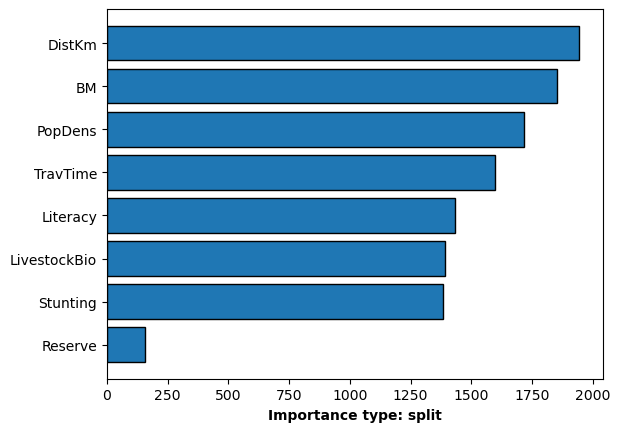

In [35]:
# Taking a look at feature importance - might break if the best model isn't LGBM!
features = np.array(automl.model.estimator.feature_name_)
importances = np.array(automl.model.estimator.feature_importances_)
sort_order = np.argsort(importances)

plt.barh(features[sort_order], importances[sort_order], edgecolor = 'black')
plt.xlabel(f'Importance type: {automl.model.estimator.importance_type}', weight = 'bold');

# Non-linear hurdle model via AutoML

What if we use AutoML to find the best regression and classification models for a two-stage hurdle model?

In [80]:
# Preparing the data for the zero and nonzero models
idxs = get_train_test_split(len(ben_lop2019), train_size = 0.7)
pp_data = preprocess_data(ben_lop2019, include_indicators = False, standardize = True, log_trans_cont = False,
                          polynomial_features = 0, train_test_idxs = idxs)

train_data, test_data = pp_data.loc[idxs['train']], pp_data.loc[idxs['test']]
pred_cols = ['BM', 'DistKm', 'PopDens', 'Stunting', 'TravTime', 'LivestockBio', 'Literacy', 'Reserve']

X_train_zero, y_train_zero, X_train_nonzero, y_train_nonzero = get_zero_nonzero_datasets(train_data, 
                                                                                         pred = False,
                                                                                         extirp_pos = False,
                                                                                         zero_columns = pred_cols, 
                                                                                         nonzero_columns = pred_cols, 
                                                                                         indicator_columns = [])
X_test, y_test = test_data.drop(columns = ['ratio']), test_data['ratio'].values

In [85]:
# Training the zero model (classifier)
zero_model = AutoML()
time_budget_mins = 2

# Specify paramaters
base_path = os.path.join('..', 'model_saves')
automl_settings = {
    'time_budget' : time_budget_mins * 60,  # in seconds
    'metric' : 'accuracy',
    'task' : 'classification',
    'log_file_name' : os.path.join(base_path, f'nonlinear_hurdle.log'),
    'seed' : 1693,
    'estimator_list' : ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 
                        'extra_tree', 'kneighbor', 'lrl1', 'lrl2'],
    'early_stop' : True,
    'verbose' : 3
}

# Train with labeled input data
zero_model.fit(X_train = X_train_zero, y_train = y_train_zero, **automl_settings)

[flaml.automl.logger: 05-23 16:22:38] {1680} INFO - task = classification
[flaml.automl.logger: 05-23 16:22:38] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 05-23 16:22:38] {1789} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 05-23 16:22:38] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree', 'kneighbor', 'lrl1', 'lrl2']
[flaml.automl.logger: 05-23 16:22:38] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 05-23 16:22:38] {2345} INFO - Estimated sufficient time budget=964s. Estimated necessary time budget=28s.
[flaml.automl.logger: 05-23 16:22:38] {2392} INFO -  at 0.2s,	estimator lgbm's best error=0.1294,	best estimator lgbm's best error=0.1294
[flaml.automl.logger: 05-23 16:22:38] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 05-23 16:22:38] {2392} INFO -  at 0.3s,	estimator lgbm's best error=0.1276,	best estimator lgbm's best error=0.1276
[flaml.automl.

In [86]:
# Training the nonzero model (regressor)
nonzero_model = AutoML()
time_budget_mins = 2

# Specify paramaters
base_path = os.path.join('..', 'model_saves')
automl_settings = {
    'time_budget' : time_budget_mins * 60,  # in seconds
    'metric' : 'mse',
    'task' : 'regression',
    'log_file_name' : os.path.join(base_path, f'nonlinear_hurdle.log'),
    'seed' : 1693,
    'estimator_list' : ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree', 'kneighbor'],
    'early_stop' : True,
    'verbose' : 3
}

# Train with labeled input data
nonzero_model.fit(X_train = X_train_nonzero, y_train = y_train_nonzero, **automl_settings)

[flaml.automl.logger: 05-23 16:24:38] {1680} INFO - task = regression
[flaml.automl.logger: 05-23 16:24:38] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 05-23 16:24:38] {1789} INFO - Minimizing error metric: mse
[flaml.automl.logger: 05-23 16:24:38] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree', 'kneighbor']
[flaml.automl.logger: 05-23 16:24:38] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 05-23 16:24:38] {2345} INFO - Estimated sufficient time budget=2776s. Estimated necessary time budget=28s.
[flaml.automl.logger: 05-23 16:24:38] {2392} INFO -  at 0.3s,	estimator lgbm's best error=0.9484,	best estimator lgbm's best error=0.9484
[flaml.automl.logger: 05-23 16:24:38] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 05-23 16:24:38] {2392} INFO -  at 0.4s,	estimator lgbm's best error=0.9006,	best estimator lgbm's best error=0.9006
[flaml.automl.logger: 05-23 16:24:38] {2

In [92]:
# Tuning the threshold for the zero model
y_pred_zero = zero_model.predict_proba(X_train)[ : , 1]

opt_thresh, metrics = test_thresholds(y_pred_zero, y_train_zero)
print(f'Best threshold was found to be {round(opt_thresh, 3)} with a TSS of {round(np.max(metrics["TSS"]), 3)}')

Best threshold was found to be 0.85 with a TSS of 0.681


In [116]:
# Composing the two best models to create a full hurdle model
y_pred_zero = zero_model.predict_proba(X_test)[ : , 1]
y_pred_nonzero = nonzero_model.predict(X_test)
y_pred = (y_pred_zero >= opt_thresh).astype(int) * y_pred_nonzero
y_pred[y_pred != 0] = np.exp(y_pred[y_pred != 0])

CLASSIFICATION PERFORMANCE
--------------------------
              precision    recall  f1-score   support

         low       0.86      0.57      0.68       560
      medium       0.29      0.47      0.36       207
        high       0.47      0.60      0.53       218

    accuracy                           0.55       985
   macro avg       0.54      0.54      0.52       985
weighted avg       0.65      0.55      0.58       985

Balanced accuracy: 54.37%


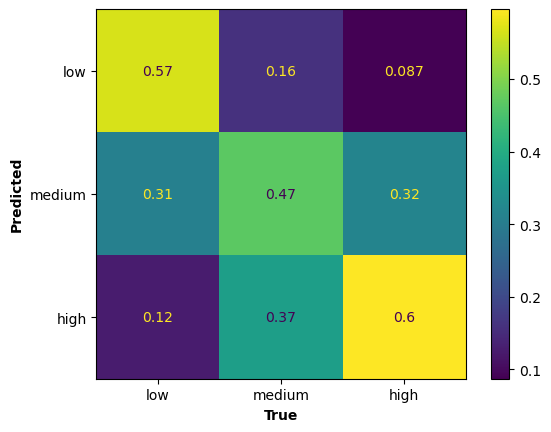


REGRESSION PERFORMANCE
----------------------
Mean absolute error: 0.869
Median absolute error: 0.275
Root mean squared error: 3.391
Root median squared error: 0.275


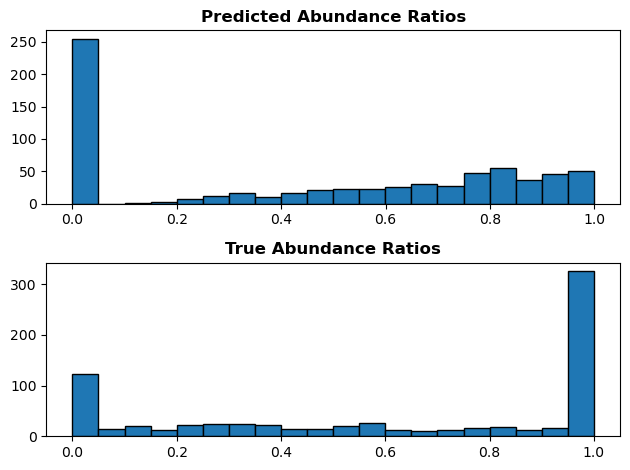

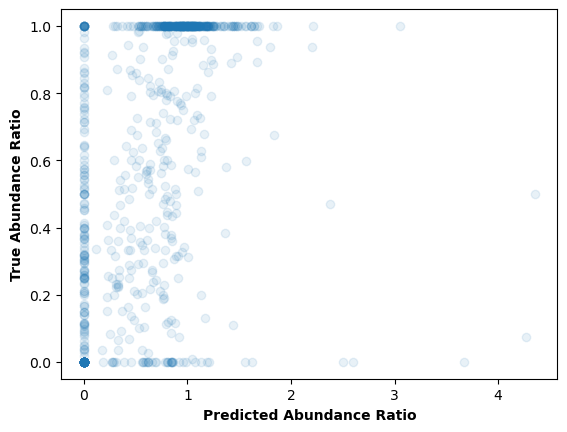

In [117]:
# Assessing classification and regression performance
pred_DI_cats = ratios_to_DI_cats(y_pred)
true_DI_cats = ratios_to_DI_cats(y_test)

print('CLASSIFICATION PERFORMANCE')
print('--------------------------')
get_classification_report(true_DI_cats, pred_DI_cats, printout = True)

print()
print('REGRESSION PERFORMANCE')
print('----------------------')
get_regression_report(y_test, y_pred, printout = True)